In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
import scipy.signal, scipy
import numpy as np
import torch, csv, random
import pandas as pd

%matplotlib inline

In [2]:
totalChanNum = 20
channelStart = 2
sampleRate = 500

dataset_unfiltered = []
for chan in range(0, totalChanNum):
    dataset_unfiltered.append([])

f = open('../P3_Experiment Data.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
next(rdr)

for line in rdr:
    idx = channelStart
    for channel in dataset_unfiltered:
        channel.append(line[idx])
        idx += 1

f.close()

dataset_unfiltered = np.array(dataset_unfiltered)
dataset_unfiltered = dataset_unfiltered.astype(np.float32)

print(dataset_unfiltered.shape)

(30, 405508)


In [3]:
####################
#  Bandpass filter #
####################
def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    nsamples = trials.shape[1]
    nchannels = trials.shape[0]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt



def movingWindow(dataset, overlap, windowWidth): 
    dataset_windows = []
    for start in range(0, len(dataset[1]) - windowWidth, int(windowWidth / overlap)):
        window = []
        for channel in dataset:
            window.append(channel[start:start+windowWidth])
        dataset_windows.append(window)
        
    dataset_windows = np.array(dataset_windows)
    dataset_windows = dataset_windows.astype(np.float32)
    return dataset_windows

In [4]:
# divide in to time window (0.5s)
dataset_window = movingWindow(dataset_unfiltered, overlap=0.5, windowWidth=256)
dataset_window = np.array(dataset_window)
dataset_window = dataset_window.astype(np.float32)


# Bandpass filtering
dataset_window = np.transpose(dataset_window, (1,2,0))
dataset_filtered = bandpass(trials=dataset_window, lo=5, hi=45, sample_rate=sampleRate)
dataset_filtered = np.transpose(dataset_filtered, (2,0,1))

dataset_filtered = np.array(dataset_filtered)
dataset_filtered = dataset_filtered.astype(np.float32)
print(dataset_filtered.shape)

(792, 30, 256)


In [5]:
# Out Autoencoder Parameters
CUDA = True
SEED = 1
BATCH_SIZE = 64
LOG_INTERVAL = 8
EPOCHS = 500
EPOCHS_INTERVAL = 50
AE_PARAMS = 32
TRAINING_SET_SIZE = 0.8

CUDA_LAUNCH_BLOCKING=1

In [6]:
# Our custom Dataset class
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, data_np):
        self.data = data_np
        
    def __len__(self):      
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx, :]

In [7]:
# Instantiate the dataset, and create training and test data sets
full_dataset = EEGDataset(dataset_filtered)

train_size = int(TRAINING_SET_SIZE * len(full_dataset))
test_size = int((len(full_dataset) - train_size)/2)
valid_size = len(full_dataset) - train_size - test_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size, test_size])

# the PyTorch DataLoader class handles randomization and feeding the Autencoder with data
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, ae_width):
        super(Autoencoder, self).__init__()

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, ae_width)
        self.fc4 = nn.Linear(ae_width, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 256)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def decode(self, x):
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

    def forward(self, x):
        x = self.encode(x.view(-1, 256))
        return self.decode(x)

In [9]:
# Instantiate the Autoencoder
model = Autoencoder(AE_PARAMS)
model.cuda()
print(model)

Autoencoder(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=256, bias=True)
)


(30, 256)


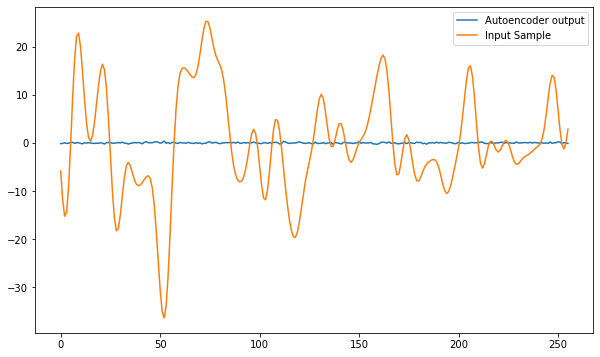

In [10]:
# Before Training, this is how well our Autoencoder can reconstruct the EEG data
print(full_dataset[1].shape)

with torch.no_grad():
    plt.figure(figsize=(10,6))
    x= model.encode(torch.from_numpy(full_dataset[1]).cuda()) 
    out = model.decode(x)
    out = out.cpu().detach().numpy()

    plt.plot(out[1], label='Autoencoder output') 
    plt.plot(full_dataset[1][1], label='Input Sample')
    plt.legend()

In [11]:
# Define how we optimizem, train, and test the Autoencoder
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = F.mse_loss(recon_batch, data.view(-1, 256), reduction='sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch = model(data)
            test_loss += F.mse_loss(recon_batch, data.view(-1, 256), reduction='sum')

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


def valid():
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch = model(data)
            valid_loss += F.mse_loss(recon_batch, data.view(-1, 256), reduction='sum')

    test_loss /= len(test_loader.dataset)
    print('====> Validation set loss: {:.4f}'.format(test_loss))


Train Epoch: 1 [0/633 (0%)]	Loss: 2766582.000000
Train Epoch: 1 [512/633 (80%)]	Loss: 3147953.000000
====> Epoch: 1 Average loss: 6529176.1896
====> Test set loss: 2861566.7500
Train Epoch: 2 [0/633 (0%)]	Loss: 7775495.000000
Train Epoch: 2 [512/633 (80%)]	Loss: 3051462.000000
====> Epoch: 2 Average loss: 6524679.6840
====> Test set loss: 2860623.0000
Train Epoch: 3 [0/633 (0%)]	Loss: 5127836.000000
Train Epoch: 3 [512/633 (80%)]	Loss: 18438086.000000
====> Epoch: 3 Average loss: 6520615.0521
====> Test set loss: 2859535.5000
Train Epoch: 4 [0/633 (0%)]	Loss: 15066342.000000
Train Epoch: 4 [512/633 (80%)]	Loss: 18266842.000000
====> Epoch: 4 Average loss: 6515649.5671
====> Test set loss: 2858253.7500
Train Epoch: 5 [0/633 (0%)]	Loss: 7631621.500000
Train Epoch: 5 [512/633 (80%)]	Loss: 2808372.000000
====> Epoch: 5 Average loss: 6509328.2275
====> Test set loss: 2856647.2500
Train Epoch: 6 [0/633 (0%)]	Loss: 3351535.500000
Train Epoch: 6 [512/633 (80%)]	Loss: 3225270.250000
====> Epoch

<Figure size 432x288 with 0 Axes>

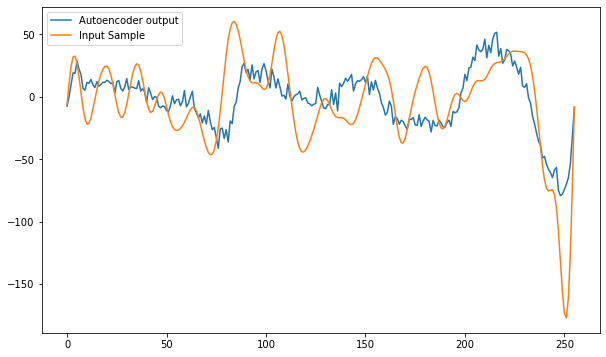

Train Epoch: 51 [0/633 (0%)]	Loss: 2367679.000000
Train Epoch: 51 [512/633 (80%)]	Loss: 1821784.625000
====> Epoch: 51 Average loss: 2268947.7030
====> Test set loss: 2065648.5000
Train Epoch: 52 [0/633 (0%)]	Loss: 2318099.000000
Train Epoch: 52 [512/633 (80%)]	Loss: 2121049.000000
====> Epoch: 52 Average loss: 2268084.4487
====> Test set loss: 2058363.6250
Train Epoch: 53 [0/633 (0%)]	Loss: 1898169.250000
Train Epoch: 53 [512/633 (80%)]	Loss: 2092038.250000
====> Epoch: 53 Average loss: 2253941.8136
====> Test set loss: 2054526.8750
Train Epoch: 54 [0/633 (0%)]	Loss: 1839181.000000
Train Epoch: 54 [512/633 (80%)]	Loss: 2416795.250000
====> Epoch: 54 Average loss: 2240595.5513
====> Test set loss: 2052835.7500
Train Epoch: 55 [0/633 (0%)]	Loss: 2298329.750000
Train Epoch: 55 [512/633 (80%)]	Loss: 2030297.250000
====> Epoch: 55 Average loss: 2234196.9921
====> Test set loss: 2046609.2500
Train Epoch: 56 [0/633 (0%)]	Loss: 1812864.500000
Train Epoch: 56 [512/633 (80%)]	Loss: 3157061.5000

<Figure size 432x288 with 0 Axes>

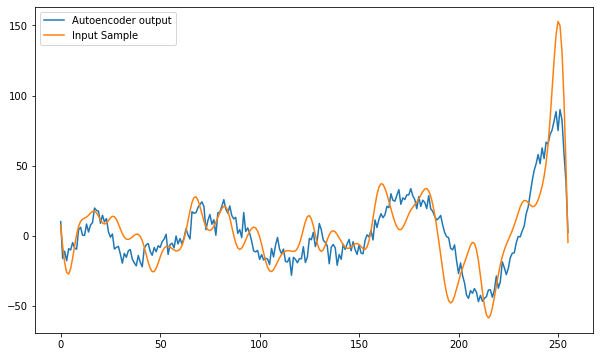

Train Epoch: 101 [0/633 (0%)]	Loss: 1516618.125000
Train Epoch: 101 [512/633 (80%)]	Loss: 1357583.000000
====> Epoch: 101 Average loss: 1720579.9431
====> Test set loss: 1688422.3750
Train Epoch: 102 [0/633 (0%)]	Loss: 1918310.250000
Train Epoch: 102 [512/633 (80%)]	Loss: 1413903.250000
====> Epoch: 102 Average loss: 1703272.8215
====> Test set loss: 1681547.7500
Train Epoch: 103 [0/633 (0%)]	Loss: 1538869.750000
Train Epoch: 103 [512/633 (80%)]	Loss: 2361358.500000
====> Epoch: 103 Average loss: 1710206.9889
====> Test set loss: 1670147.1250
Train Epoch: 104 [0/633 (0%)]	Loss: 1919473.625000
Train Epoch: 104 [512/633 (80%)]	Loss: 1352418.500000
====> Epoch: 104 Average loss: 1702982.8626
====> Test set loss: 1670992.2500
Train Epoch: 105 [0/633 (0%)]	Loss: 2167252.500000
Train Epoch: 105 [512/633 (80%)]	Loss: 1414562.250000
====> Epoch: 105 Average loss: 1692632.7709
====> Test set loss: 1666813.3750
Train Epoch: 106 [0/633 (0%)]	Loss: 1691082.250000
Train Epoch: 106 [512/633 (80%)]	L

<Figure size 432x288 with 0 Axes>

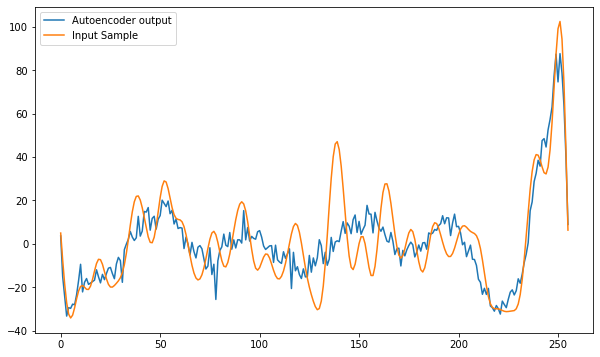

Train Epoch: 151 [0/633 (0%)]	Loss: 1379871.000000
Train Epoch: 151 [512/633 (80%)]	Loss: 1215030.125000
====> Epoch: 151 Average loss: 1399392.5814
====> Test set loss: 1381053.3750
Train Epoch: 152 [0/633 (0%)]	Loss: 1740698.875000
Train Epoch: 152 [512/633 (80%)]	Loss: 1663669.000000
====> Epoch: 152 Average loss: 1398104.9226
====> Test set loss: 1374310.1250
Train Epoch: 153 [0/633 (0%)]	Loss: 1414438.250000
Train Epoch: 153 [512/633 (80%)]	Loss: 1479216.500000
====> Epoch: 153 Average loss: 1395485.3207
====> Test set loss: 1371416.5000
Train Epoch: 154 [0/633 (0%)]	Loss: 1636640.875000
Train Epoch: 154 [512/633 (80%)]	Loss: 1187539.500000
====> Epoch: 154 Average loss: 1393667.1848
====> Test set loss: 1369967.7500
Train Epoch: 155 [0/633 (0%)]	Loss: 1133753.750000
Train Epoch: 155 [512/633 (80%)]	Loss: 1202243.250000
====> Epoch: 155 Average loss: 1388418.9258
====> Test set loss: 1368074.0000
Train Epoch: 156 [0/633 (0%)]	Loss: 1179068.750000
Train Epoch: 156 [512/633 (80%)]	L

<Figure size 432x288 with 0 Axes>

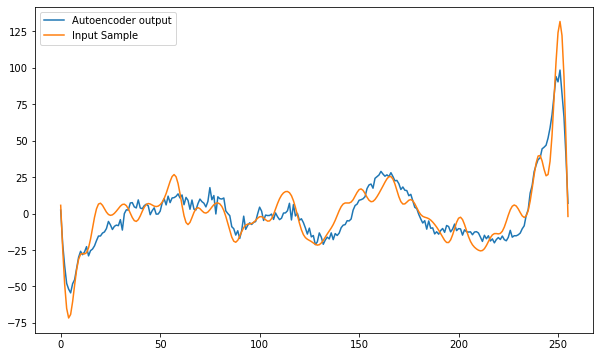

Train Epoch: 201 [0/633 (0%)]	Loss: 1254110.875000
Train Epoch: 201 [512/633 (80%)]	Loss: 1337787.250000
====> Epoch: 201 Average loss: 1270588.4676
====> Test set loss: 1258733.6250
Train Epoch: 202 [0/633 (0%)]	Loss: 1154704.250000
Train Epoch: 202 [512/633 (80%)]	Loss: 1897670.500000
====> Epoch: 202 Average loss: 1272436.6888
====> Test set loss: 1256924.6250
Train Epoch: 203 [0/633 (0%)]	Loss: 1669031.875000
Train Epoch: 203 [512/633 (80%)]	Loss: 1115193.750000
====> Epoch: 203 Average loss: 1274960.8720
====> Test set loss: 1258381.7500
Train Epoch: 204 [0/633 (0%)]	Loss: 1073309.250000
Train Epoch: 204 [512/633 (80%)]	Loss: 1199122.500000
====> Epoch: 204 Average loss: 1276296.9542
====> Test set loss: 1255612.6250
Train Epoch: 205 [0/633 (0%)]	Loss: 955958.750000
Train Epoch: 205 [512/633 (80%)]	Loss: 1482923.000000
====> Epoch: 205 Average loss: 1277076.1580
====> Test set loss: 1256961.5000
Train Epoch: 206 [0/633 (0%)]	Loss: 1313535.750000
Train Epoch: 206 [512/633 (80%)]	Lo

<Figure size 432x288 with 0 Axes>

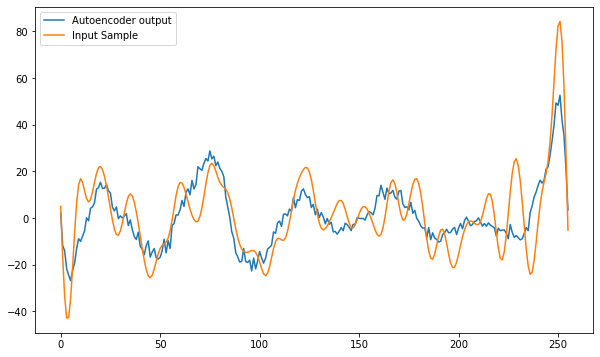

Train Epoch: 251 [0/633 (0%)]	Loss: 1895848.000000
Train Epoch: 251 [512/633 (80%)]	Loss: 1136631.750000
====> Epoch: 251 Average loss: 1220206.4202
====> Test set loss: 1204239.2500
Train Epoch: 252 [0/633 (0%)]	Loss: 1300940.750000
Train Epoch: 252 [512/633 (80%)]	Loss: 1106244.250000
====> Epoch: 252 Average loss: 1205207.9558
====> Test set loss: 1201455.3750
Train Epoch: 253 [0/633 (0%)]	Loss: 1219878.000000
Train Epoch: 253 [512/633 (80%)]	Loss: 1000576.875000
====> Epoch: 253 Average loss: 1202212.2212
====> Test set loss: 1199246.0000
Train Epoch: 254 [0/633 (0%)]	Loss: 1562499.750000
Train Epoch: 254 [512/633 (80%)]	Loss: 1157987.375000
====> Epoch: 254 Average loss: 1194849.6177
====> Test set loss: 1197810.6250
Train Epoch: 255 [0/633 (0%)]	Loss: 1089630.750000
Train Epoch: 255 [512/633 (80%)]	Loss: 1009803.750000
====> Epoch: 255 Average loss: 1191446.1801
====> Test set loss: 1195255.8750
Train Epoch: 256 [0/633 (0%)]	Loss: 977162.750000
Train Epoch: 256 [512/633 (80%)]	Lo

<Figure size 432x288 with 0 Axes>

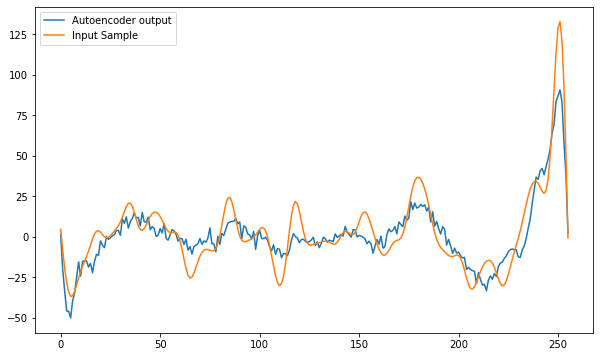

Train Epoch: 301 [0/633 (0%)]	Loss: 1114879.875000
Train Epoch: 301 [512/633 (80%)]	Loss: 1109589.125000
====> Epoch: 301 Average loss: 1167498.4518
====> Test set loss: 1139887.8750
Train Epoch: 302 [0/633 (0%)]	Loss: 1287933.375000
Train Epoch: 302 [512/633 (80%)]	Loss: 1202056.000000
====> Epoch: 302 Average loss: 1128854.2180
====> Test set loss: 1128089.0000
Train Epoch: 303 [0/633 (0%)]	Loss: 1175021.750000
Train Epoch: 303 [512/633 (80%)]	Loss: 1305420.000000
====> Epoch: 303 Average loss: 1117089.3649
====> Test set loss: 1126066.7500
Train Epoch: 304 [0/633 (0%)]	Loss: 1138338.000000
Train Epoch: 304 [512/633 (80%)]	Loss: 1118428.875000
====> Epoch: 304 Average loss: 1109808.4929
====> Test set loss: 1124180.2500
Train Epoch: 305 [0/633 (0%)]	Loss: 1041907.437500
Train Epoch: 305 [512/633 (80%)]	Loss: 1139347.500000
====> Epoch: 305 Average loss: 1104970.5340
====> Test set loss: 1122313.5000
Train Epoch: 306 [0/633 (0%)]	Loss: 991730.500000
Train Epoch: 306 [512/633 (80%)]	Lo

<Figure size 432x288 with 0 Axes>

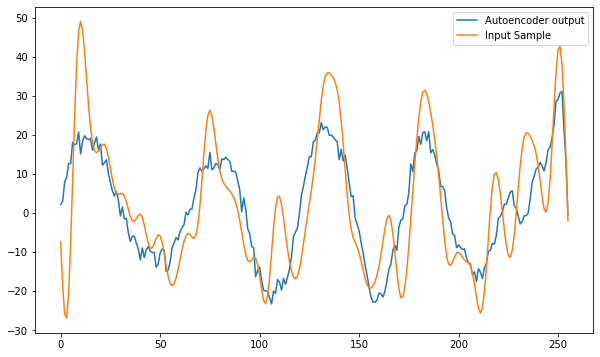

Train Epoch: 351 [0/633 (0%)]	Loss: 1100707.000000
Train Epoch: 351 [512/633 (80%)]	Loss: 1243215.875000
====> Epoch: 351 Average loss: 1038817.2765
====> Test set loss: 1066968.8750
Train Epoch: 352 [0/633 (0%)]	Loss: 896531.937500
Train Epoch: 352 [512/633 (80%)]	Loss: 812376.375000
====> Epoch: 352 Average loss: 1039292.1390
====> Test set loss: 1065461.6250
Train Epoch: 353 [0/633 (0%)]	Loss: 1156398.000000
Train Epoch: 353 [512/633 (80%)]	Loss: 1070822.000000
====> Epoch: 353 Average loss: 1038657.8957
====> Test set loss: 1068502.5000
Train Epoch: 354 [0/633 (0%)]	Loss: 1072425.500000
Train Epoch: 354 [512/633 (80%)]	Loss: 826168.375000
====> Epoch: 354 Average loss: 1037054.6919
====> Test set loss: 1065219.3750
Train Epoch: 355 [0/633 (0%)]	Loss: 1158370.875000
Train Epoch: 355 [512/633 (80%)]	Loss: 1310130.125000
====> Epoch: 355 Average loss: 1037733.3270
====> Test set loss: 1063512.1250
Train Epoch: 356 [0/633 (0%)]	Loss: 959771.375000
Train Epoch: 356 [512/633 (80%)]	Loss:

<Figure size 432x288 with 0 Axes>

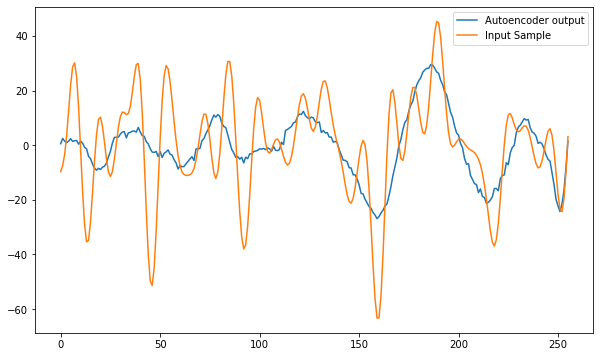

Train Epoch: 401 [0/633 (0%)]	Loss: 992115.750000
Train Epoch: 401 [512/633 (80%)]	Loss: 1058482.875000
====> Epoch: 401 Average loss: 1011727.0711
====> Test set loss: 1038624.1250
Train Epoch: 402 [0/633 (0%)]	Loss: 885443.812500
Train Epoch: 402 [512/633 (80%)]	Loss: 947734.500000
====> Epoch: 402 Average loss: 1020169.8894
====> Test set loss: 1042685.8125
Train Epoch: 403 [0/633 (0%)]	Loss: 830423.937500
Train Epoch: 403 [512/633 (80%)]	Loss: 1223129.375000
====> Epoch: 403 Average loss: 1039999.9621
====> Test set loss: 1030429.6875
Train Epoch: 404 [0/633 (0%)]	Loss: 845667.187500
Train Epoch: 404 [512/633 (80%)]	Loss: 1004604.250000
====> Epoch: 404 Average loss: 1053983.2986
====> Test set loss: 1042931.8750
Train Epoch: 405 [0/633 (0%)]	Loss: 1037298.000000
Train Epoch: 405 [512/633 (80%)]	Loss: 904667.500000
====> Epoch: 405 Average loss: 1059276.1074
====> Test set loss: 1068413.5000
Train Epoch: 406 [0/633 (0%)]	Loss: 1026759.000000
Train Epoch: 406 [512/633 (80%)]	Loss: 1

<Figure size 432x288 with 0 Axes>

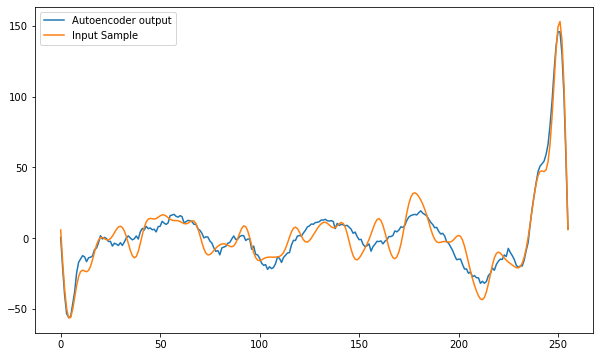

Train Epoch: 451 [0/633 (0%)]	Loss: 1016107.875000
Train Epoch: 451 [512/633 (80%)]	Loss: 910295.250000
====> Epoch: 451 Average loss: 975835.8041
====> Test set loss: 1003262.5000
Train Epoch: 452 [0/633 (0%)]	Loss: 945342.187500
Train Epoch: 452 [512/633 (80%)]	Loss: 842988.500000
====> Epoch: 452 Average loss: 980744.0569
====> Test set loss: 1002294.5000
Train Epoch: 453 [0/633 (0%)]	Loss: 842228.312500
Train Epoch: 453 [512/633 (80%)]	Loss: 1020497.187500
====> Epoch: 453 Average loss: 970940.5624
====> Test set loss: 1002072.2500
Train Epoch: 454 [0/633 (0%)]	Loss: 1059323.625000
Train Epoch: 454 [512/633 (80%)]	Loss: 849297.562500
====> Epoch: 454 Average loss: 972794.2749
====> Test set loss: 1002777.3125
Train Epoch: 455 [0/633 (0%)]	Loss: 798305.062500
Train Epoch: 455 [512/633 (80%)]	Loss: 1189434.750000
====> Epoch: 455 Average loss: 966535.8483
====> Test set loss: 1000193.7500
Train Epoch: 456 [0/633 (0%)]	Loss: 754533.125000
Train Epoch: 456 [512/633 (80%)]	Loss: 860466.

<Figure size 432x288 with 0 Axes>

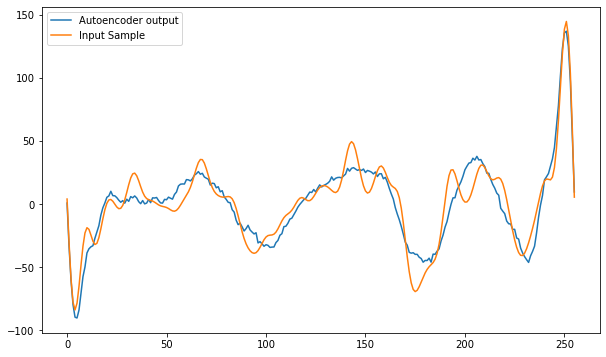

In [12]:
# Train the Autoencoder on our EEG data!
for epoch in range(1, EPOCHS+1):
    train(epoch)
    test(epoch)

    if epoch % EPOCHS_INTERVAL == 0:
        with torch.no_grad():
            plt.figure()
            plt.figure(figsize=(10, 6))
            sample = full_dataset[random.randint(0, len(full_dataset)-1)]
            x= model.encode(torch.from_numpy(sample).cuda()) 
            out = model.decode(x)
            out = out.cpu().detach().numpy()

            plt.plot(out[1], label='Autoencoder output') 
            plt.plot(sample[1], label='Input Sample')
            plt.legend()
            plt.show()

In [13]:
# Save the trained
torch.save(model.state_dict(), 'Autoencoder_EEG_LinearModel.pt')

In [14]:
# Load a trained model
model = Autoencoder(AE_PARAMS)
model.load_state_dict(torch.load('Autoencoder_EEG_LinearModel.pt'))
model.eval()

# Push it onto the GPU
model.cuda()

Autoencoder(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=256, bias=True)
)

<Figure size 432x288 with 0 Axes>

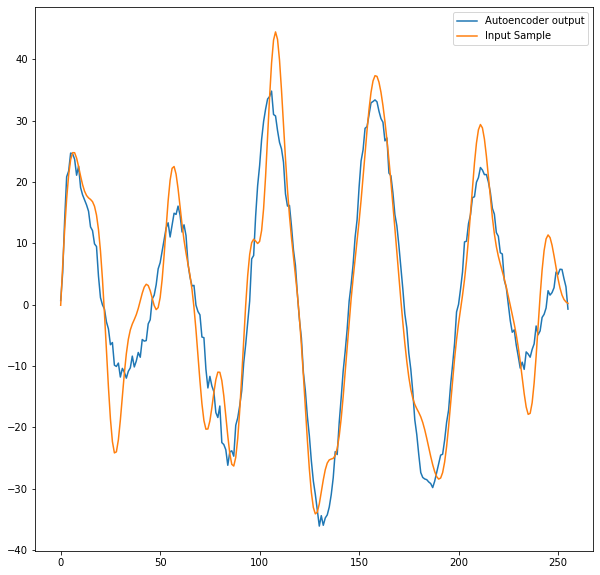

In [15]:
# Test the loaded model
with torch.no_grad():
    plt.figure()
    plt.figure(figsize=(10,10))
    sample = full_dataset[random.randint(0,len(full_dataset))]
    x= model.encode(torch.from_numpy(sample).cuda()) 
    out = model.decode(x)
    out = out.cpu().detach().numpy()

    randIdx = random.randint(0, totalChanNum)
    plt.plot(out[randIdx], label='Autoencoder output') 
    plt.plot(sample[randIdx], label='Input Sample')
    plt.legend()
    plt.show()

====> Test set loss: 978381.5000


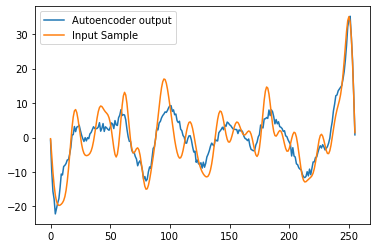

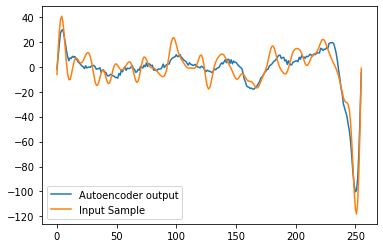

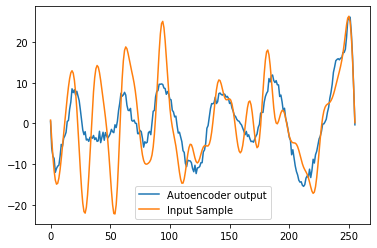

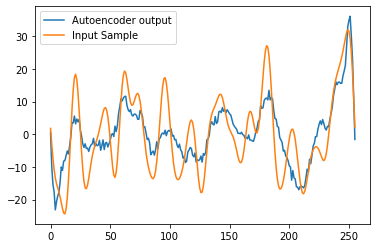

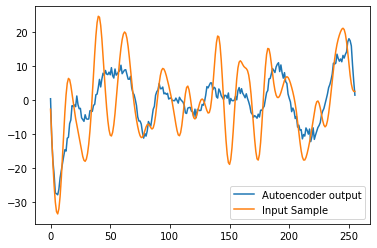

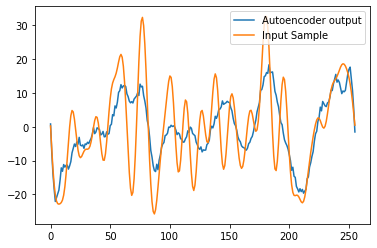

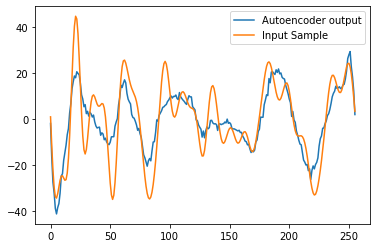

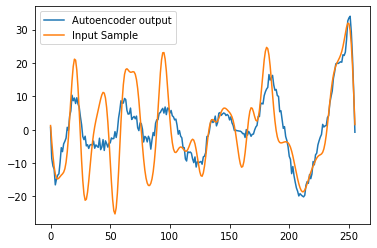

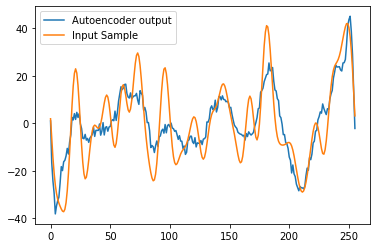

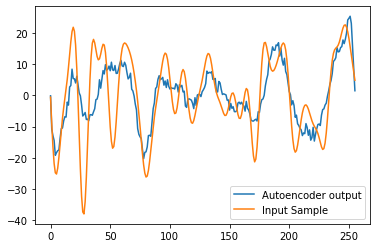

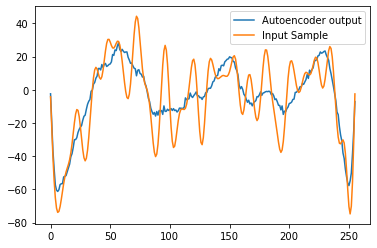

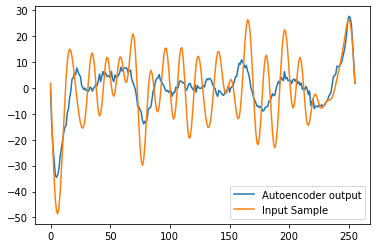

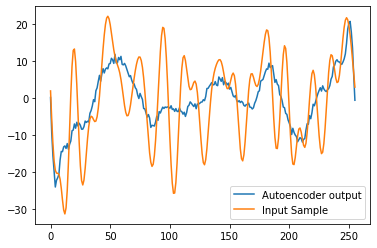

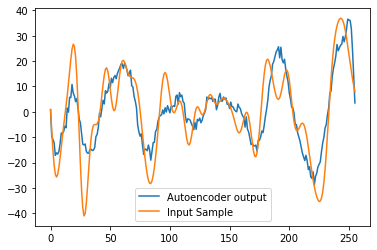

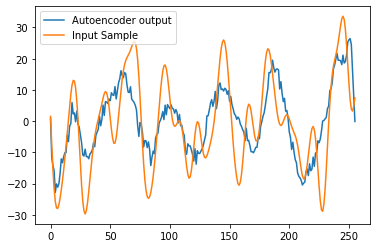

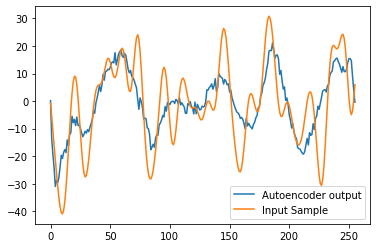

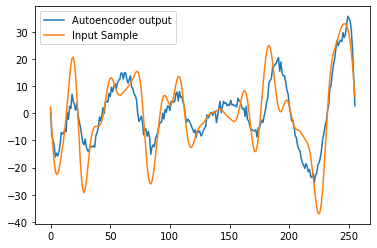

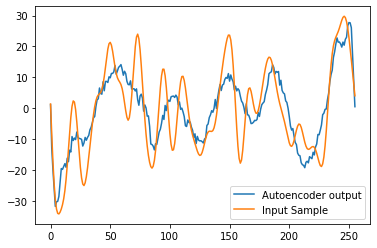

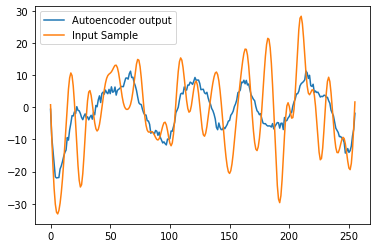

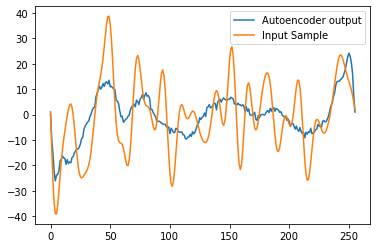

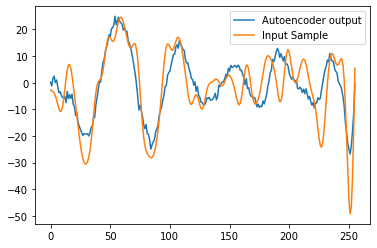

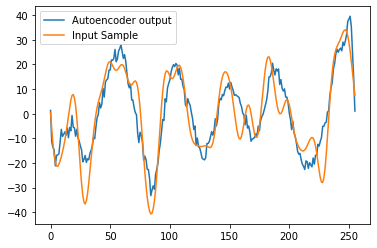

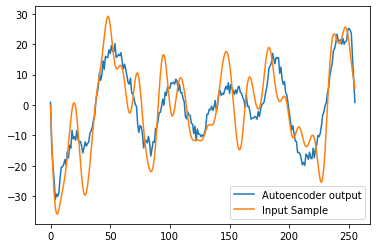

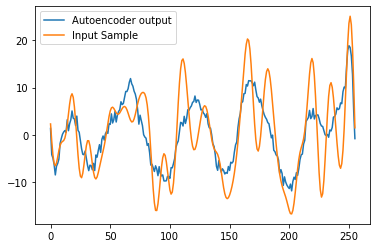

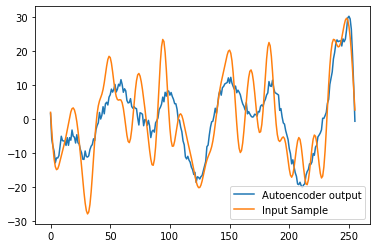

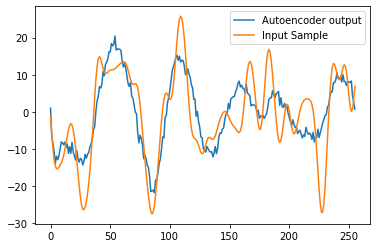

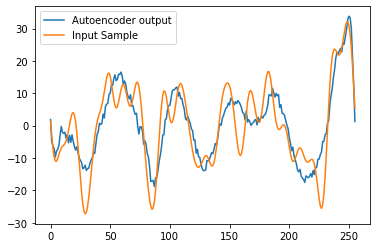

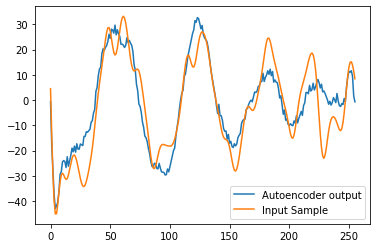

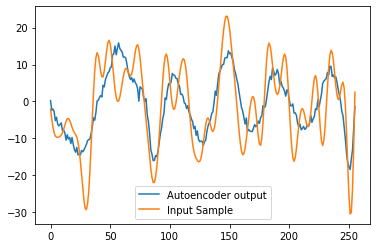

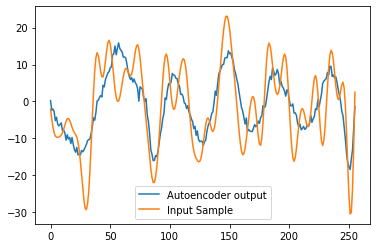

In [16]:
test(0)

with torch.no_grad():
        plt.figure()
        sample = test_dataset[random.randint(0, len(test_dataset))]
        x= model.encode(torch.from_numpy(sample).cuda()) 
        out = model.decode(x)
        out = out.cpu().detach().numpy()

        for chan in range(0, totalChanNum):
                plt.plot(out[chan], label='Autoencoder output') 
                plt.plot(sample[chan], label='Input Sample')
                plt.legend()
                plt.show()
